In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve
from sklearn.metrics import confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from keras.models import Sequential
from keras import layers
import itertools
from sklearn.utils import resample



%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes, model_name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, best = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if best:
        plt.savefig('confmat'+model_name+'best.jpeg', bbox_inches = 'tight', transparent = False)
    elif normalize:
        plt.savefig('confmat'+model_name+'normalize.jpeg', bbox_inches = 'tight', transparent = False)
    else:
        plt.savefig('confmat'+model_name+'.jpeg', bbox_inches = 'tight', transparent = False)
    
    plt.show()


def confusionMatrix(testLabels, predictions, modelName, best = False, normalize = False):
    confMat = confusion_matrix(testLabels, predictions)
    tn, fp, fn, tp = confusion_matrix(testLabels, predictions).ravel()
    print(tn, fp, fn, tp)
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    print("Precision: ", p)
    print("Recall: ", r)
    print("F1-Score: ", 2*p*r/(p+r))
    classes = [0, 1]
    plot_confusion_matrix(confMat, classes, modelName, best = best, normalize = normalize, title = 'Confusion Matrix for '+ modelName)

#### Global Variables

In [3]:
base = 'XCV_SMPT'
base2 = 'XCV_SMPT2'

# column names of all labels
fatigue = base + 'FATG'
headache = base + 'HEAD'
heart_prob = base + 'HRT'
muscle_aches = base + 'ACHE'
cough_breath = base + 'COGH'
dizziness = base + 'DIZZ'
anxiety = base + 'ANX'
other = base + 'OTH'


columns_map = {}

inpfile = open('labelMapping.txt')
lines = inpfile.readlines()
for line in lines:
    key, value = line.split('=')
    key = key.strip()
    value = value.strip()[1:-1]
    columns_map[key] = value
    
# 0: "Don't Know/Missing/Refuse to Answer"
values_map = {'XCV_CVDSVRE':{1: "No COVID19\nSymptoms", 2: "Mild COVID19\nSymptoms", 3: "Moderate COVID19\nSymptoms", 
                             4: "Severe COVID19\nSymptoms"},
             'XCV_CVDSEEK': {1: "Sought Medical Care\nfor COVID19", 2: "Didn't Seek Medical\nCare for COVID19"},
             'EMV_DISRMEDI':{1: "Able to Get Medication\nfor COVID19", 2: "Unable to Get Medication\nfor COVID19", 3: "Have Not Needed\nMedication for COVID19"},
             'ACV_INTER':{5: "Had Access to \nAll of Internet/Phone/\nTablet/Computer/Audiovideo"},
             'PKV_PREVSUM':{},
             'EMV_FEELSOCI':{1: "Feel More Socially Connected Since COVID19", 2: "Feel Less Socially Connected Since COVID19", 3: "Fell About the Same Socially Connected"},
             'DMV_RE_AGE':{1: "None-Hispanic White, < 65 Yrs Old", 2: "None-Hispanic White, 65-74 Yrs Old", 3: "None-Hispanic White, 75-84 Yrs Old",
                          4: "None-Hispanic White, 85+ Yrs Old", 5: "None-Hispanic Black, < 65 Yrs Old", 6: "None-Hispanic Black, 65-74 Yrs Old", 
                          7: "None-Hispanic Black, 75-84 Yrs Old", 8: "None-Hispanic Black, 85+ Yrs Old", 9: "Hispanic, < 65 Yrs Old", 10: "Hispanic, 65-74 Yrs Old", 
                          11: "Hispanic, 75+ Yrs Old", 12: "Other/Unknown Race/Ethnicity, < 65 Yrs Old", 13: "Other/Unknown Race/Ethnicity, 65-74 Yrs Old",
                          14: "Other/Unknown Race/Ethnicity, 75+ Yrs Old"},
              'XCV_SUSPECT': {1: "Patient Suspected They Had COVID19", 2: "Patient Didn't Suspect They Had COVID19"},
              'XCV_CVDHOSP': {1: "Hospitalized Overnight for COVID19", 2: "Wasn't Hospitalized Overnight for COVID19"},
              'PKV_INFOMOST': {1: "Rely Most on Traditional News for COVID19 Info", 2: "Rely Most on Social Media for COVID19 Info",
                              3: "Rely Most on Comments&Guidance from Govt. for COVID19 Info", 4: "Rely Most on Other Webpages/Internet for COVID19 Info",
                              5: "Rely Most on Friends or Family for COVID19 Info", 6: "Rely Most on Healthcare Providers for COVID19 Info"}
             }
for i in range(16):
    values_map['PKV_PREVSUM'][i] = str(i) + " COVID19 Preventive Behaviors"
for i in range(1, 5):
    values_map['ACV_INTER'][i] = "Had Access to" + str(i) + "\n of Internet/Phone/Tablet/\nComputer/Audiovideo"
for k in list(values_map.keys()):
    values_map[k][0] = "Don't Know/Missing/\nRefuse to Answer"

#### Preprocessing Data

In [4]:
############ HELPER FUNCS FOR PREPROCESSING ###############################
def joinDatasets(dbname1, dbname2):
    # read in both datasets
    db_2020f = pd.read_csv(dbname1, low_memory=False)
    db_2021w = pd.read_csv(dbname2, low_memory=False)

    # get rid of excessive features
    db_2020f = db_2020f.loc[:, :'HLV_ECIGNOW']
    db_2021w = db_2021w.loc[:, :'HLV_ECIGNOW']
    
    # join two datasets
    db_joined = db_2021w.append(db_2020f, sort = False)
    
    return db_joined

def popTrivialRiskFactors(db):
    db.pop('INV_SPPROXY')
    db.pop('EMV_DISRMASK')
    db.pop('HLV_OCSTROKE')
    db.pop('HLV_OCBRKHIP')
    db.pop('PKV_RSNCAUSE')
    db.pop('PKV_RSNSIDE')
    db.pop('PKV_RSNPREV')
    db.pop('PKV_RSNSER')
    db.pop('PKV_RSNNEED')
    db.pop('PKV_RSNTIME')
    db.pop('ACV_PLACPART')
    db.pop('HLV_OCALZDEM')
    db.pop('PKV_RSNRISK')
    db.pop('PKV_RSNHEAL')
    db.pop('PKV_RSNTRUST')
    db.pop('PKV_RSNOTHER')
    db.pop('HLV_OCCFAIL')
    db.pop('EMV_DISRFOOD')
    db.pop('HLV_OCMYOCAR')
    db.pop('XCV_ANTPAY')
    db.pop('EMV_DISRSUPP')
    db.pop('ACV_TELMEDT2')
    db.pop('HLV_ECIGONE')
    db.pop('HLV_OCCHD')
    db.pop('HLV_ECIGNOW')
    db.pop('XCV_ANTBDTST')
    db.pop('HLV_OCCANCER')
    db.pop('XCV_COVIDEV')
    db.pop('HLV_OCOSTEOP')
    db.pop('DMV_OTHRLANG')
    db.pop('XCV_COVSWAB')
    db.pop('XCV_ANTRESLT')
    db.pop('DMV_H_OPMDCD')
    db.pop('DMV_INCOME')
    
    db.pop('DMV_AGECAT')
    db.pop('DMV_RACE')

    return db

def popRedundantFeatures(db):
    """Pop out all features we don't need"""
    db = popTrivialRiskFactors(db)
    
    # popping out features we don't need (that could potentially be noise)
    db.pop('COVID_ID')
    db.pop('CVROUND')
    db.pop('VERSION')
    db.pop('INV_LANG')
    db.pop('INV_INTWEEK')
    db.pop('XCV_SWABWAIT')
    db.pop('XCV_ANTWAIT')
    db.pop('PKV_VACMON1')
    db.pop('PKV_VACMON2')
    db.pop('PKV_VACYR1')
    db.pop('PKV_VACYR2')
    db.pop('HLV_AUTOCND')
    db.pop('ACV_COVIDCAR')
    db.pop('ACV_NOCARSUM')
    
    # popping out detailed preventive features as we already have the count of preventive features
    prev = 'PKV_PREV'
    db.pop(prev + 'WASH')
    db.pop(prev + 'SANI')
    db.pop(prev + 'FACE')
    db.pop(prev + 'TISS')
    db.pop(prev + 'MASK')
    db.pop(prev + 'CLEA')
    db.pop(prev + 'CONT')
    db.pop(prev + 'DIST')
    db.pop(prev + 'GRP')
    db.pop(prev + 'SHEL')
    db.pop(prev + 'FOOD')
    db.pop(prev + 'SUPP')
    db.pop(prev + 'MEDI')
    db.pop(prev + 'CONS')
    db.pop(prev + 'PPL')
    
    # popping out detailed reasons for not getting treated
    notreat = 'XCV_CVD'
    db.pop(notreat + 'EXPEN')
    db.pop(notreat + 'NTAVA')
    db.pop(notreat + 'SYMNS')
    db.pop(notreat + 'OTHER')
    
    # popping out detailed reasons for suspecting COVID
    susp = 'XCV_SUS'
    db.pop(susp + 'FEVER')
    db.pop(susp + 'COUGH')
    db.pop(susp + 'RNOSE')
    db.pop(susp + 'SNEEZ')
    db.pop(susp + 'SRTBR')
    db.pop(susp + 'HDACH')
    db.pop(susp + 'THROA')
    db.pop(susp + 'NAUSE')
    db.pop(susp + 'VOMIT')
    db.pop(susp + 'FATIG')
    db.pop(susp + 'CHILL')
    db.pop(susp + 'MUSCL')
    db.pop(susp + 'LTSSM')
    db.pop(susp + 'LAPPE')
    db.pop(susp + 'DIAH')
    db.pop(susp + 'OTHER')
    
    # popping out detailed info sources
    info = 'PKV_INFO'
    db.pop(info + 'NEWS')
    db.pop(info + 'SOCI')
    db.pop(info + 'GOVT')
    db.pop(info + 'INT')
    db.pop(info + 'FRIE')
    db.pop(info + 'HCPR')
    
    # popping out detailed reasons for not wanting to get the vaccine
    vacc = 'PKV_NO'
    db.pop(vacc + 'SICK')
    db.pop(vacc + 'NEED')
    db.pop(vacc + 'CAUSE')
    db.pop(vacc + 'SIDE')
    db.pop(vacc + 'PREV')
    db.pop(vacc + 'SERIUS')
    db.pop(vacc + 'REC')
    db.pop(vacc + 'GET')
    db.pop(vacc + 'LIKE')
    db.pop(vacc + 'ACCESS')
    db.pop(vacc + 'FIND')
    db.pop(vacc + 'FORGOT')
    db.pop(vacc + 'AFFORD')
    db.pop(vacc + 'BEFORE')
    db.pop(vacc + 'AVAIL')
    db.pop(vacc + 'WORTH')
    db.pop(vacc + 'TIME')
    db.pop(vacc + 'RISK')
    db.pop(vacc + 'HEALTH')
    db.pop(vacc + 'TRUST')
    db.pop(vacc + 'OTHER')
    db.pop(vacc + 'APPT')
    
    nocare = 'ACV_TYP'
    db.pop(nocare + 'URGNT')
    db.pop(nocare + 'SURGE')
    db.pop(nocare + 'DIAGN')
    db.pop(nocare + 'TREAT')
    db.pop(nocare + 'CHKUP')
    db.pop(nocare + 'DRUGS')
    db.pop(nocare + 'DENTA')
    db.pop(nocare + 'VISIO')
    db.pop(nocare + 'HEAR')
    db.pop(nocare + 'MENT')
    
    #identifier
    db = popFeaturesAllWlIdentifier(db,'ACV_DIR')
    db = popFeaturesAllWlIdentifier(db,'ACV_RSN')
    db = popFeaturesAllWlIdentifier(db,'ACV_CCL')
    db = popFeaturesAllWlIdentifier(db,'ACV_CLS')
    db = popFeaturesAllWlIdentifier(db,'ACV_PRI')
    db = popFeaturesAllWlIdentifier(db,'ACV_RED')
    db = popFeaturesAllWlIdentifier(db,'ACV_OMD')
    db = popFeaturesAllWlIdentifier(db,'ACV_TRA')
    db = popFeaturesAllWlIdentifier(db,'ACV_HOU')
    db = popFeaturesAllWlIdentifier(db,'ACV_RSK')
    db = popFeaturesAllWlIdentifier(db,'ACV_OYR')
    
    return db

def popFeaturesAllWlIdentifier(db, identifier):
    toPop = [c for c in db.columns if identifier in c]
    for feat in toPop:
        db.pop(feat)
    
    return db

def replaceMissingData(db):
    """replacing missing data with 0 and refused-to-answer as 0"""
    db.fillna(0, inplace = True)
    db.replace('D', 0, regex = True, inplace = True)
    db.replace('R', 0, regex = True, inplace = True)

    for c in db.columns:
        db[c] = pd.to_numeric(db[c])
        
    return db

def groupFeatures(db, toGroup, newFeature, descr):
    """group subgroups together"""
    for feat in toGroup:
        db[feat].replace(2, 0, regex = True, inplace = True)   ################################## db[feat].replace(2, -1, regex = True, inplace = True)
        
    db[newFeature] = db[toGroup].sum(axis=1, numeric_only=True)
    
    for feat in toGroup:
        db.pop(feat)
        
    columns_map[newFeature] = descr
    
    return db


#############################################################################

def preProcess():
    db_joined = joinDatasets('2020F.csv', '2021W.csv')
    
    # filter out all patients who don't have COVID
    db = db_joined[db_joined[fatigue].notnull()]
    db = db[db[fatigue] != 'R']
    
    # construct label: patient has any one of the persistent symptoms
    conditions = [(db[fatigue] == '2') & (db[headache] == '2') & 
                  (db[heart_prob] == '2') & (db[muscle_aches] == '2') &
                  (db[cough_breath] == '2') & (db[dizziness] == '2') &
                  (db[anxiety] == '2') & (db[other] == '2')]
    choices = [0]
    db[base] = np.select(conditions, choices, default = 1)
    
    conditions = [(db['HLV_AUTOIMRX'] == '1') & (db['HLV_AUTOIMM'] == '1')]
    choices = [1]
    db['HLV_AUTOANY'] = np.select(conditions, choices, default = db['HLV_AUTOIMM'])
    columns_map['HLV_AUTOANY'] = 'Weak immune system'
    db.pop('HLV_AUTOIMM')
    db.pop('HLV_AUTOIMRX')
    
    #####################################################################
#     conditions2 = [(db[heart_prob] == '2') & (db[muscle_aches] == '2') &
#               (db[cough_breath] == '2')]
                   
#     db[base2] = np.select(conditions2, choices, default = 1)
    #####################################################################
    
    db = popRedundantFeatures(db)
    
    db = replaceMissingData(db)

    # knowledge on the measures experts recommend for COVID
    db = groupFeatures(db, ['PKV_RECWASH', 'PKV_RECMASK', 'PKV_RECAVOI', 'PKV_RECSTAY', 'PKV_RECMEDI'], 'PKV_REC', 
                      'Knowledge of COVID measures recommended by experts')
    db.pop('PKV_REC')
    db = groupFeatures(db, ['ACV_COMPDESK', 'ACV_COMPPHON', 'ACV_COMPTAB', 'ACV_INTERNET', 'ACV_AUDIOVID'], 'ACV_INTER',
                      'Access to internet/phone/tablet/computer/audiovideo')

    
    return db

    
db = preProcess()


### Need to map all values back to semantic labels in the end!

In [5]:
# get all the sub-labels for each symptom
label_fatigue = db.pop(fatigue)
label_headache = db.pop(headache)
label_heartprob = db.pop(heart_prob)
label_muscleaches = db.pop(muscle_aches)
label_coughbreath = db.pop(cough_breath)
label_dizziness = db.pop(dizziness)
label_anxiety = db.pop(anxiety)
label_other = db.pop(other)

In [6]:
print(db)

      DMV_SEX  DMV_RE_AGE  DMV_CBSA  DMV_REGION  DMV_MA_FLAG  DMV_PARTD  \
53          2           2       1.0         3.0          3.0        1.0   
69          2           3       1.0         3.0          1.0        2.0   
84          1           2       1.0         1.0          3.0        1.0   
85          2           9       1.0         4.0          1.0        2.0   
127         2           4       2.0         3.0          1.0        1.0   
...       ...         ...       ...         ...          ...        ...   
9466        1           3       1.0         4.0          1.0        0.0   
9635        1           1       1.0         4.0          2.0        0.0   
9654        2           5       1.0         3.0          1.0        0.0   
9677        2          11       1.0         2.0          3.0        0.0   
9684        1           4       2.0         2.0          3.0        0.0   

      ACV_PLACKIND  ACV_TELMED  ACV_TELMEDT1  ACV_TELMEDBE  ...  HLV_OCBETES  \
53               1 

In [7]:
# split training and testing data
train, test = train_test_split(db, test_size = 0.4, stratify = db[base], random_state = 42)
print(train.shape, test.shape)

(540, 52) (361, 52)


In [8]:
# db_majority = train[train[base2] == 1]
# print(db_majority.shape)
# db_minority = train[train[base2] == 0]
# print(db_minority.shape)

# y_train2 = train.pop(base2)
# y_test2 = test.pop(base2)
# train.pop(base)
# test.pop(base)
# X_train2 = train
# X_test2 = test

In [9]:
db_majority = train[train[base] == 1]
print(db_majority.shape)
db_minority = train[train[base] == 0]

db_min_upsampled = resample(db_minority, replace = True, n_samples = 369, random_state=123)
print(db_min_upsampled.shape)
db_upsampled = pd.concat([db_majority, db_min_upsampled])
train = db_upsampled

(369, 52)
(369, 52)


In [10]:
y_train = train.pop(base)
y_test = test.pop(base)
# train.pop(base2)
# test.pop(base2)
X_train = train
X_test = test

print(X_train.shape, X_test.shape)

(738, 51) (361, 51)


In [11]:
label_all = db.pop(base)
# label_all2 = db.pop(base2)


In [12]:
print(X_train.shape, X_test.shape)

(738, 51) (361, 51)


#### Helper Functions

In [13]:
def trainTuneTest(learner, parameters, X, y, num_splits):
    test_scores = []
    # Divide the data into training/test splits
    skf = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = 42)
    fold_count = 0
    for train, test in skf.split(X, y):
        fold_count += 1
        print("Fold %d:" % fold_count)
        X_tr, X_te = X.iloc[train], X.iloc[test]
        y_tr, y_te = y.iloc[train], y.iloc[test]
        tuned = GridSearchCV(learner, parameters, cv = 3)

        tuned.fit(X_tr, y_tr)
        print("Best parameters:", tuned.best_params_)
        print("Tuning Set Score:", tuned.best_score_)
        test_scores.append(tuned.score(X_te, y_te))
    return test_scores

#### **ALL** - Logistic Regression

In [14]:
def adaBoosting(X_train, X_test, y_train, y_test):
    adb = AdaBoostClassifier(n_estimators=120, learning_rate=0.2).fit(X_train, y_train)
    confusionMatrix(y_test, adb.predict(X_test), 'AdaBoost')
    score = adb.score(X_test, y_test)
    return score

79 36 76 170
Precision:  0.8252427184466019
Recall:  0.6910569105691057
F1-Score:  0.7522123893805309


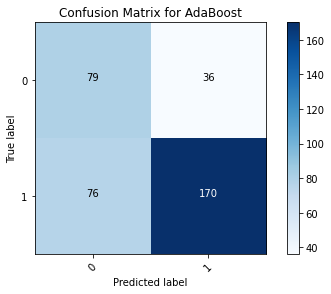

0.6897506925207756


In [15]:
score_adaboost = adaBoosting(X_train, X_test, y_train, y_test)
print(score_adaboost)

In [117]:
def logReg(X_train, X_test, y_train, y_test):
    # do tuning for complexity
    lgr = LogisticRegression(max_iter = 10**4).fit(X_train, y_train)
    confusionMatrix(y_test, lgr.predict(X_test), 'Logistic Regression')
    score = lgr.score(X_test, y_test)
    return score

67 48 75 171
Precision:  0.7808219178082192
Recall:  0.6951219512195121
F1-Score:  0.7354838709677419


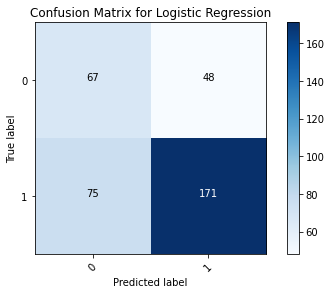

0.6592797783933518


In [118]:
score_logreg = logReg(X_train, X_test, y_train, y_test)
print(score_logreg)

#### **ALL** - Tuned Logistic Regression

In [119]:
def logRegTuned(X, y):
    lgr = LogisticRegression(max_iter = 10**5)
    c = {'C': np.logspace(-5,0,6)}
    test_scores = trainTuneTest(lgr, c, X, y, 5)
    return test_scores

In [120]:
score_logregTuned = logRegTuned(db, label_all)
score_logregTuned = np.mean(score_logregTuned)
print(score_logregTuned)

Fold 1:
Best parameters: {'C': 0.01}
Tuning Set Score: 0.6902777777777779
Fold 2:
Best parameters: {'C': 1e-05}
Tuning Set Score: 0.6823881973259566
Fold 3:
Best parameters: {'C': 1e-05}
Tuning Set Score: 0.6823881973259566
Fold 4:
Best parameters: {'C': 0.01}
Tuning Set Score: 0.6851717381281697
Fold 5:
Best parameters: {'C': 1e-05}
Tuning Set Score: 0.6823881973259566
0.6859116022099447


#### **ALL** - Decision Tree

In [196]:
def decTree(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier().fit(X_train, y_train)
    confusionMatrix(y_test, dt.predict(X_test), 'Decision Tree')
    score = dt.score(X_test, y_test)
    return score

25 90 51 195
Precision:  0.6842105263157895
Recall:  0.7926829268292683
F1-Score:  0.7344632768361581


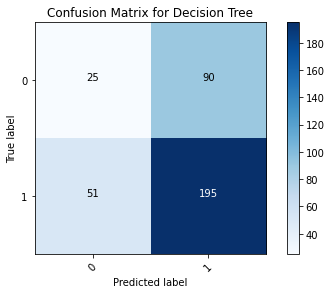

0.6094182825484764


In [197]:
score_dt = decTree(X_train, X_test, y_train, y_test)
print(score_dt)

#### **ALL** - Tuned Decision Tree

In [14]:
def decTreeTuned(X, y):
    dt = DecisionTreeClassifier()
    num_features = {'max_features': [.01, .1, .5, 1, "sqrt"]}
    test_scores = trainTuneTest(dt, num_features, X, y, 5)
    return test_scores

In [15]:
score_dtTuned = decTreeTuned(db, label_all)

score_dtTuned = np.mean(score_dtTuned)
print(score_dtTuned)

Fold 1:
Best parameters: {'max_features': 0.1}
Tuning Set Score: 0.6041666666666666
Fold 2:
Best parameters: {'max_features': 'sqrt'}
Tuning Set Score: 0.5977869986168741
Fold 3:
Best parameters: {'max_features': 0.5}
Tuning Set Score: 0.6338923467035501
Fold 4:
Best parameters: {'max_features': 0.1}
Tuning Set Score: 0.5977178423236515
Fold 5:
Best parameters: {'max_features': 0.1}
Tuning Set Score: 0.6130071461502996
0.623695518723143


#### **ALL** - Random Forest

In [229]:
def randForest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators = 200).fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    confusionMatrix(y_test, rf.predict(X_test), 'Random Forest')
    confusionMatrix(y_test, rf.predict(X_test), 'Random Forest', normalize = True)
    return score

32 83 20 226
Precision:  0.7313915857605178
Recall:  0.9186991869918699
F1-Score:  0.8144144144144144


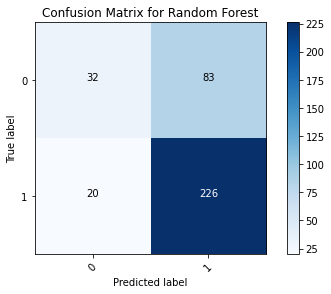

32 83 20 226
Precision:  0.7313915857605178
Recall:  0.9186991869918699
F1-Score:  0.8144144144144144


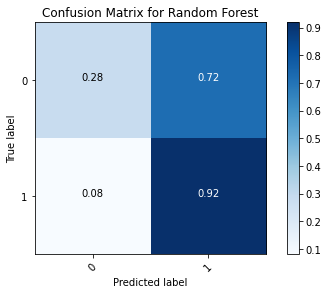

0.7146814404432132


In [230]:
score_rf = randForest(X_train, X_test, y_train, y_test)
print(score_rf)

#### **ALL** - Tuned Random Forest

In [132]:
def randForestTuned(X, y):
    rf = RandomForestClassifier(n_estimators = 200)
    params = {'max_features': [.01, .1, .5, 1, "sqrt"], 'min_samples_leaf': [1, 5, 10, 50, 100]}
    test_scores = trainTuneTest(rf, params, X, y, 5)
    return test_scores

In [133]:
score_rfTuned = randForestTuned(db, label_all)
score_rfTuned = np.mean(score_rfTuned)
print(score_rfTuned)

Fold 1:
Best parameters: {'max_features': 0.5, 'min_samples_leaf': 10}
Tuning Set Score: 0.7125
Fold 2:


KeyboardInterrupt: 

In [14]:
def findRiskFactors(rf):
    ##### find the risk factors ################
    risk_factors = {}
    importances = rf.feature_importances_
    

    # map these to feature strings so we can see what they are 
    for feature, importance in zip(X_train.columns, importances):
        risk_factors[feature] = importance
    risk_factors_plt = sorted(list(risk_factors.items()), key = lambda x : x[1], reverse = True)
    print(risk_factors_plt[:2])
    risk_factors_trivial = sorted(list(risk_factors.items()), key = lambda x : x[1])
    
    X, Y = [], []
    for key, value in risk_factors_plt[:10]:
        X.append(columns_map[key])
        Y.append(value)
        
    ##### plot the risk factors ################
#     colors = list(Color('#083573').range_to(Color('#9FCAE1'), 15))
#     colors = [c.rgb for c in colors]
    colors = mcolors.LinearSegmentedColormap.from_list('', ['#A4CCE3','#084488'])
    
    plt.barh(X, Y, color = colors(Y/max(Y)))
    plt.ylabel("Feature Names")
    plt.xlabel("Importance")
    plt.title("Risk Factors from Random Forest")
    plt.gca().invert_yaxis()
    plt.savefig('riskfactors_rf.jpeg', bbox_inches = 'tight', transparent = False)
    plt.show()
    
    return risk_factors_plt[:5]

def plotFactorValues(frames, factors):
    for j, f in enumerate(frames):
        w = f.shape[0] / 15
    
        newplot = f.plot(x = factors[j][0], kind = 'barh', stacked = True, mark_right = True, color = {'Percent_pos': '#08306B', 'Percent_neg': '#73B2D8'}, 
            edgecolor = 'white', width = w)

        f = f.reset_index()
        h = 1
        for i in range(len(f)): # height = 10
            pos, neg = f.loc[i, 'Percent_pos'], f.loc[i, 'Percent_neg']
            x_pos, x_neg = i - w/3.4, i - w/3.4
            y_pos = h * pos / 2
            y_neg = h * pos + h * neg / 2
            if pos:
                plt.text(y_pos, x_pos, str(np.round(pos*100, 1)) + '%', ha='center', color = 'white')
            if neg:
                plt.text(y_neg, x_neg, str(np.round(neg*100, 1)) + '%', ha='center', color = 'white')
        t = columns_map[factors[j][0]] + ', Predicted'
        ind_wrap = len(t) // 2
        while t[ind_wrap].isalpha():
            ind_wrap -= 1
        tit = t[:ind_wrap] + "\n" + t[ind_wrap:]
        plt.title(tit, loc = 'left', fontsize = 12, fontname='DejaVu Sans')
        plt.legend(["Subjects wl Long COVID", "Subjects w/o Long COVID"], bbox_to_anchor = (1.11, 1.2))
        plt.savefig('percentages'+str(j)+'.jpeg', bbox_inches = 'tight', transparent = False)

    
def plotFactorValuesTrue(frames, factors):
    for j, f in enumerate(frames):
        w = f.shape[0] / 15
    
        newplot = f.plot(x = factors[j][0], kind = 'barh', stacked = True, 
             mark_right = True, color = {'Percent_pos': '#08306B', 'Percent_neg': '#73B2D8'}, edgecolor = 'white', width = w)

        f = f.reset_index()
        h = 1
        for i in range(len(f)): # height = 10
            pos, neg = f.loc[i, 'Percent_pos'], f.loc[i, 'Percent_neg']
            x_pos, x_neg = i - w/3.4, i - w/3.4
            y_pos = h * pos / 2
            y_neg = h * pos + h * neg / 2
            if pos:
                plt.text(y_pos, x_pos, str(np.round(pos*100, 1)) + '%', ha='center', color = 'white')
            if neg:
                plt.text(y_neg, x_neg, str(np.round(neg*100, 1)) + '%', ha='center', color = 'white')
        t = columns_map[factors[j][0]] + ', Actual'
        ind_wrap = len(t) // 2
        while t[ind_wrap].isalpha():
            ind_wrap += 1
        tit = t[:ind_wrap] + "\n" + t[ind_wrap:]
        plt.title(tit, loc = 'left', fontsize = 12, fontname='DejaVu Sans')
        plt.legend(["Subjects wl Long COVID", "Subjects w/o Long COVID"], bbox_to_anchor = (1.11, 1.2))
        plt.savefig('percentages'+str(j)+'True.jpeg', bbox_inches = 'tight', transparent = False)



def findFactorValuesTrue(factors, merged):
    pos = merged[merged[base] == 1]
    neg = merged[merged[base] == 0]
    frames = []
    for f, _ in factors:
        pos_counts = pos[f].value_counts(sort=True, ascending = False)
        pos_counts = pd.DataFrame(pos_counts.reset_index().values, columns = [f, 'Count_pos'])
        
        neg_counts = neg[f].value_counts(sort=True, ascending = False)
        neg_counts = pd.DataFrame(neg_counts.reset_index().values, columns = [f, 'Count_neg'])
        
        all_counts = pd.merge(pos_counts, neg_counts, on = f, how = 'outer').fillna(0).astype(int)
        all_counts['Sum'] = all_counts['Count_pos'] + all_counts['Count_neg']
        all_counts['Percent_pos'] = all_counts['Count_pos'] / all_counts['Sum']
        all_counts['Percent_neg'] = all_counts['Count_neg'] / all_counts['Sum']

        all_counts.pop('Count_pos')
        all_counts.pop('Count_neg')
        all_counts.pop('Sum')
        
        all_counts = all_counts.sort_values(by = [f], ascending = False)
        
        ####### Map all_counts[f] Here!! ##############
        all_counts[f].replace(values_map[f], inplace=True)
            
        
        frames.append(all_counts)

        
    plotFactorValuesTrue(frames, factors)

def findFactorValues(factors, merged):
    pos = merged[merged['PREDS'] == 1]
    neg = merged[merged['PREDS'] == 0]
    frames = []
    for f, _ in factors:
        pos_counts = pos[f].value_counts(sort=True, ascending = False)
        pos_counts = pd.DataFrame(pos_counts.reset_index().values, columns = [f, 'Count_pos'])
        
        neg_counts = neg[f].value_counts(sort=True, ascending = False)
        neg_counts = pd.DataFrame(neg_counts.reset_index().values, columns = [f, 'Count_neg'])
        
        all_counts = pd.merge(pos_counts, neg_counts, on = f, how = 'outer').fillna(0).astype(int)
        all_counts['Sum'] = all_counts['Count_pos'] + all_counts['Count_neg']
        all_counts['Percent_pos'] = all_counts['Count_pos'] / all_counts['Sum']
        all_counts['Percent_neg'] = all_counts['Count_neg'] / all_counts['Sum']

        all_counts.pop('Count_pos')
        all_counts.pop('Count_neg')
        all_counts.pop('Sum')
        
        all_counts = all_counts.sort_values(by = [f], ascending = False)
        
        ####### Map all_counts[f] Here!! ##############
        all_counts[f].replace(values_map[f], inplace=True)
            
        
        frames.append(all_counts)

        
    plotFactorValues(frames, factors)

    

def randForestBest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators = 75, max_depth = 5, max_leaf_nodes = 15, max_features = 0.5, min_samples_leaf = 25, random_state = 42).fit(X_train, y_train)
    preds = rf.predict(X_test)
    confusionMatrix(y_test, preds, 'Random Forest', best = True)
    confusionMatrix(y_test, preds, 'Random Forest', normalize = True)
    score = rf.score(X_test, y_test)
    riskFactors = findRiskFactors(rf)
    preds = pd.DataFrame(preds)
    preds = preds.reset_index(drop = True)
    preds.columns = ['PREDS']
    X_test_m = X_test.reset_index(drop = True)
    merged = pd.concat([X_test_m, preds], axis=1)
    findFactorValues(riskFactors, merged)
    merged_true = pd.concat([db, label_all], axis=1)
    findFactorValuesTrue(riskFactors, merged_true)
    
   
    
    return score
    


print(X_test.shape)
print(X_train.shape)


(361, 51)
(738, 51)


72 43 57 189
Precision:  0.8146551724137931
Recall:  0.7682926829268293
F1-Score:  0.7907949790794979


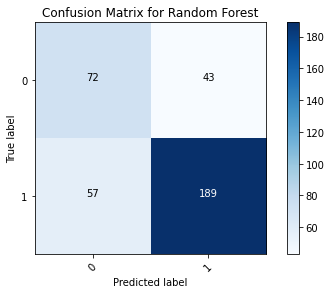

72 43 57 189
Precision:  0.8146551724137931
Recall:  0.7682926829268293
F1-Score:  0.7907949790794979


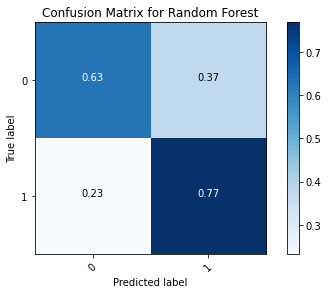

[('XCV_CVDSVRE', 0.33390925588536624), ('XCV_CVDSEEK', 0.13348739140712354)]


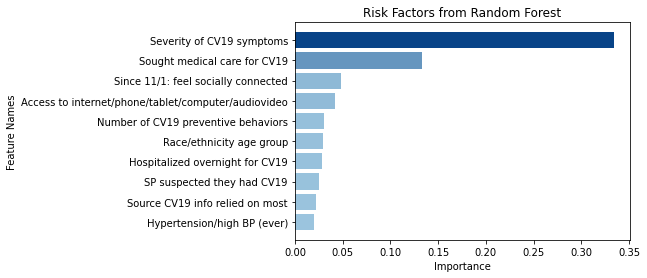

0.7229916897506925


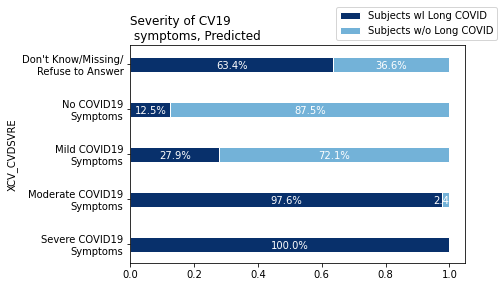

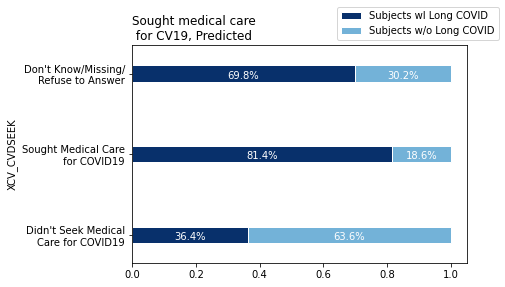

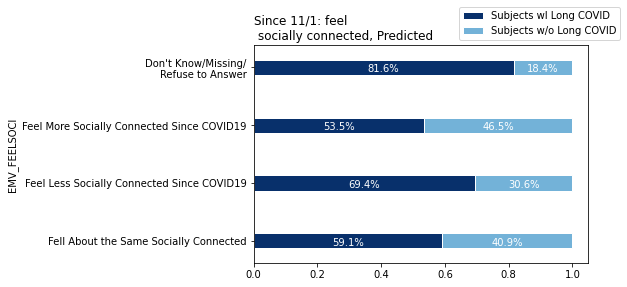

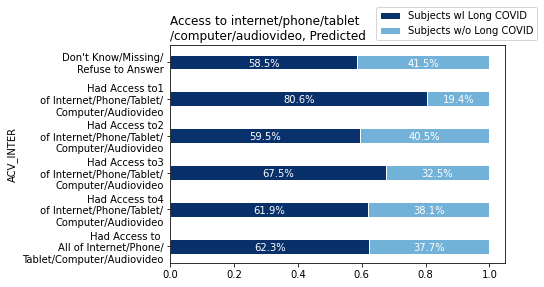

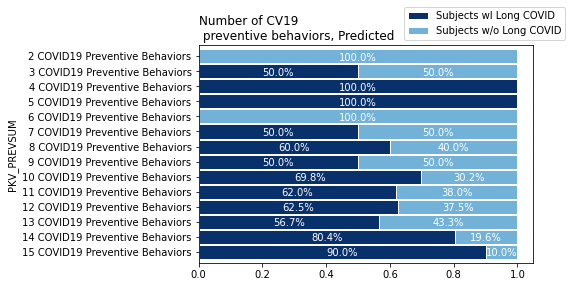

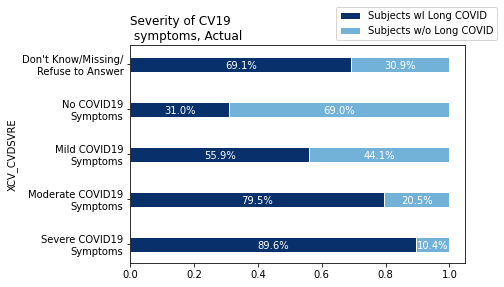

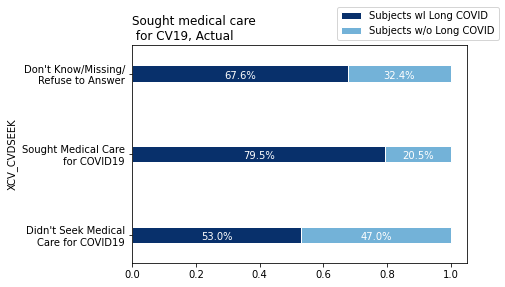

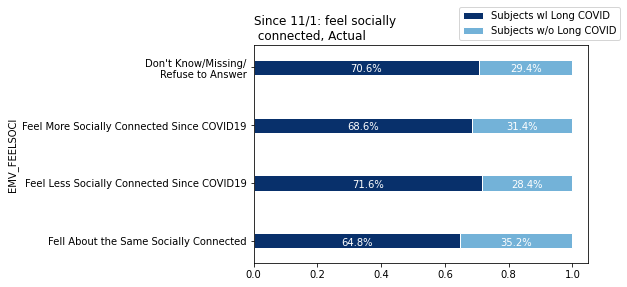

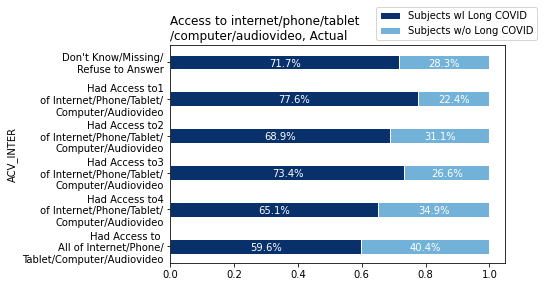

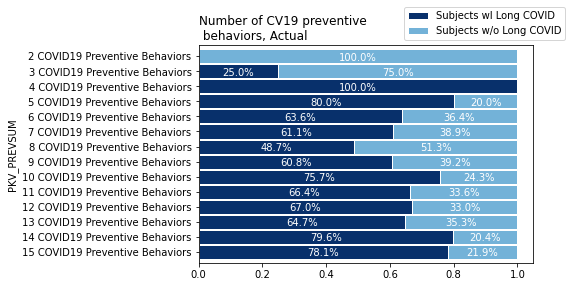

In [15]:
score_randforest_best = randForestBest(X_train, X_test, y_train, y_test)
print(score_randforest_best)

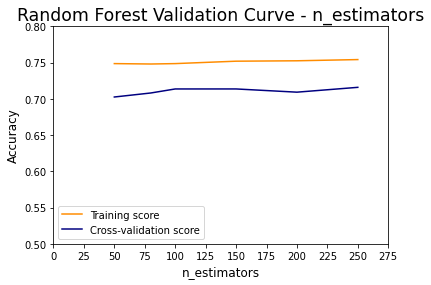

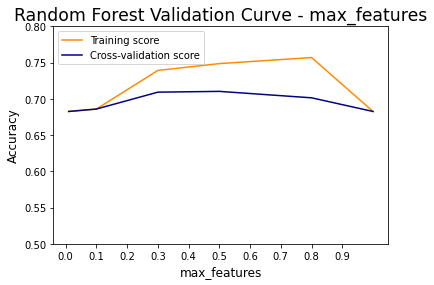

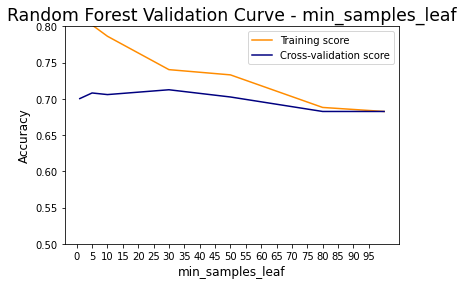

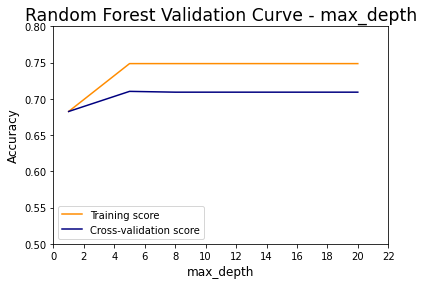

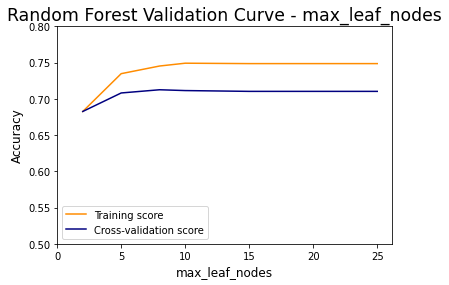

In [159]:
# n_estimators = 75, max_depth = 5, max_leaf_nodes = 15, max_features = 0.5, min_samples_leaf = 25, random_state = 42
def VCOneParam(param, values, X, y, n_estimators=75, max_features=.5, min_samples_leaf=25, max_depth = 5, max_leaf_nodes = 15):
    if param == 'n_estimators':
        rf = RandomForestClassifier(max_features = max_features, min_samples_leaf = min_samples_leaf, max_depth = max_depth, 
                                    max_leaf_nodes = max_leaf_nodes, random_state = 42)
        r = range(0, 300, 25)
    elif param == 'max_features':
        rf = RandomForestClassifier(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf, max_depth = max_depth, 
                                    max_leaf_nodes = max_leaf_nodes, random_state = 42)
        r = np.arange(0, 1, .1)
    elif param == 'min_samples_leaf':
        rf = RandomForestClassifier(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth, 
                                    max_leaf_nodes = max_leaf_nodes, random_state = 42)
        r = range(0, 100, 5)
    elif param == 'max_depth':
        rf = RandomForestClassifier(n_estimators = n_estimators, max_features = max_features, min_samples_leaf = min_samples_leaf, 
                                    max_leaf_nodes = max_leaf_nodes, random_state = 42)
        r = range(0, 24, 2)
    elif param == 'max_leaf_nodes':
        rf = RandomForestClassifier(n_estimators = n_estimators, max_features = max_features, min_samples_leaf = min_samples_leaf, 
                                    max_depth = max_depth, random_state = 42)
        r = range(0, 30, 5)
        
    train_scores, test_scores = validation_curve(rf, X, y, param_name = param, param_range = values, cv = 3, n_jobs=3)
    train_scores_mean = np.mean(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    plotVC(values, param, train_scores_mean, test_scores_mean, r)
    
def plotVC(gam, param, train_scores_mean, test_scores_mean, r):
    plt.plot(gam, train_scores_mean, label="Training score", color="darkorange")
    plt.plot(gam, test_scores_mean, label="Cross-validation score", color="navy")
    plt.title("Random Forest Validation Curve - "+param, fontsize="xx-large")
    plt.xlabel(param,fontsize="large")
    plt.ylabel("Accuracy",fontsize="large")
    plt.ylim(0.5, 0.8)
    plt.xticks(r)
    plt.legend(loc="best")
    plt.savefig('RandomForestValidationCurve' + param+ '.jpeg', bbox_inches = 'tight', transparent = False)
    plt.show()


def plotValidationCurveRF(X,y):
    params = ['n_estimators', 'max_features', 'min_samples_leaf', 'max_depth', 'max_leaf_nodes']
    values = [[50, 80, 100, 150, 200, 250], [.01, .1, .3, .5, .8, 1], [1, 5, 10, 30, 50, 80, 100], [1, 5, 8, 10, 12, 15, 20], [2, 5, 8, 10, 15, 20, 25]]
    for i in range(len(params)):
        VCOneParam(params[i], values[i], X, y)
    
plotValidationCurveRF(db,label_all)
    


#### **ALL** - SVM

In [149]:
def svm(X_train, X_test, y_train, y_test):
    svm = SVC(kernel = 'rbf', C = 1, gamma = 0.01).fit(X_train, y_train)
    score = svm.score(X_test, y_test)
    confusionMatrix(y_test, svm.predict(X_test), 'SVM')
    return score

60 55 65 181
Precision:  0.7669491525423728
Recall:  0.7357723577235772
F1-Score:  0.7510373443983402


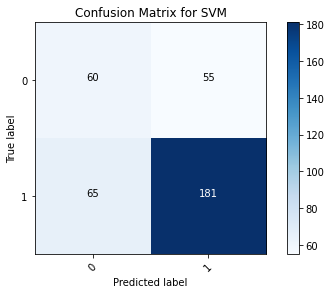

0.667590027700831


In [150]:
score_svm = svm(X_train, X_test, y_train, y_test)
print(score_svm)

In [151]:
#print(np.array(X_train))

# for i in np.array(X_train):
#     for j in i:
#         if type(j) == str:
#             print(j)
#X_train.astype(str).astype('int64')
print(1/ (X_train.shape[1] * np.array(X_train).var()))
print(X_train.shape[1])

0.005343832448658382
51


#### **ALL** - Tuned SVM

In [16]:
def svmTuned(X, y):
    svm = SVC(kernel = 'rbf')
    #'gamma': np.logspace(-10,-2,9), [4.37423 * 10**(-7)]
    #np.logspace(-10,-6,5)
    params = {'C': np.logspace(-3,3,7), 'gamma': np.logspace(-5,-2,4)}
    test_scores = trainTuneTest(svm, params, X, y, 5)
    return test_scores

In [17]:
score_svmTuned = svmTuned(db, label_all)

score_svmTuned = np.mean(score_svmTuned)
print(score_svmTuned)

Fold 1:
Best parameters: {'C': 1.0, 'gamma': 0.01}
Tuning Set Score: 0.6902777777777778
Fold 2:
Best parameters: {'C': 1.0, 'gamma': 0.01}
Tuning Set Score: 0.6879437528815121
Fold 3:
Best parameters: {'C': 1.0, 'gamma': 0.01}
Tuning Set Score: 0.6990548639926232
Fold 4:
Best parameters: {'C': 1.0, 'gamma': 0.01}
Tuning Set Score: 0.6948824343015213
Fold 5:
Best parameters: {'C': 1.0, 'gamma': 0.01}
Tuning Set Score: 0.6893326417704011
0.6925782688766114


### why does C and gamma always go to the smallest??

#### **ALL** - Naive Bayes

In [220]:
def naiveBayes(X_train, X_test, y_train, y_test):
    gauss_nb = GaussianNB().fit(X_train, y_train)
    comp_nb = ComplementNB().fit(X_train, y_train)
    confusionMatrix(y_test, comp_nb.predict(X_test), 'Naive Bayes')
    score_g = gauss_nb.score(X_test, y_test)
    score_c = comp_nb.score(X_test, y_test)
    return score_g, score_c

65 50 88 158
Precision:  0.7596153846153846
Recall:  0.6422764227642277
F1-Score:  0.696035242290749


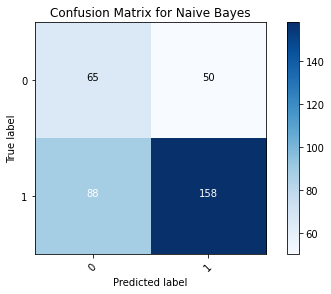

0.667590027700831 0.6177285318559557


In [221]:
score_gnb, score_cnb = naiveBayes(X_train, X_test, y_train, y_test)
print(score_gnb, score_cnb)

#### **ALL** - Tuned Naive Bayes (ComplementNB)

In [156]:
def naiveBayesTunedComp(X, y):
    comp_nb = ComplementNB()
    params = {'alpha': np.logspace(-3, 2, 6)}
    test_scores = trainTuneTest(comp_nb, params, X, y, 5)
    return test_scores


In [157]:
score_cnbTuned = naiveBayesTunedComp(db, label_all)
score_cnbTuned = np.mean(score_cnbTuned)
print(score_cnbTuned)

Fold 1:
Best parameters: {'alpha': 100.0}
Tuning Set Score: 0.6166666666666667
Fold 2:
Best parameters: {'alpha': 100.0}
Tuning Set Score: 0.6240606270170587
Fold 3:
Best parameters: {'alpha': 100.0}
Tuning Set Score: 0.586624020285846
Fold 4:
Best parameters: {'alpha': 100.0}
Tuning Set Score: 0.5852639465191333
Fold 5:
Best parameters: {'alpha': 100.0}
Tuning Set Score: 0.5963001383125864
0.6536771025168815


#### Summarizing Performance Scores of All Models

In [158]:
## print validation test scores

models = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM", "Naive Bayes-ComplementNB"]
scores_orig = [score_logreg, score_dt, score_rf, score_svm, score_cnb]
scores_tuned = [score_logregTuned, score_dtTuned, score_rfTuned, score_svmTuned, score_cnbTuned]

print("|%25s | %30s | %30s|" % (" ", "Score of Original Model", "Score of Tuned Model"))
print("|" + "-" * 91 + "|")

for i in range(len(models)):
    print("|%25s | %30.5f | %30.5f|" % (models[i], scores_orig[i], scores_tuned[i]))
    print("|" + "-" * 91 + "|")
    
print()
print("Score for Best Random Forest:", 0.7229916897506925)

|                          |        Score of Original Model |           Score of Tuned Model|
|-------------------------------------------------------------------------------------------|
|      Logistic Regression |                        0.65928 |                        0.68591|
|-------------------------------------------------------------------------------------------|
|            Decision Tree |                        0.62604 |                        0.65042|
|-------------------------------------------------------------------------------------------|
|            Random Forest |                        0.72299 |                        0.72028|
|-------------------------------------------------------------------------------------------|
|                      SVM |                        0.66759 |                        0.69258|
|-------------------------------------------------------------------------------------------|
| Naive Bayes-ComplementNB |                        0.61773 